# Homework 3 Part 1

**1.** For this question, you need to write a Hadoop streaming program in python to compute the pair-wise correlation between attributes. First, you need to download the dataset named diabetes.csv from the class webpage and transfer the file to AWS master node. Next, you need to upload the dataset to HDFS. Each line in the input file has the following information:

        preg,plas,pres,skin,insu,mass,pedi,age,class

Your mapper should discard the last column in each line (which corresponds to the class attribute) and generates only key-value pairs involving the rest of the 8 attributes. You may hard-code the attribute names directly into the mapper program. Your reducer will process the mapper outputs and produces the following key-value pair: 
- Key is name of attribute pair: e.g., (preg,plas).
- Value is correlation between the attribute pair.

After you have successfully executed the code, download the results from HDFS and store them in a file named results.txt.

**Deliverable:** Submit the mapper.py, reducer.py, and results.txt file along with a screen shot that shows the EMR cluster usage. 

**2.** How cold is the weather condition in Lansing during winter? How hot is it during summer? Have you ever wondered how accurate can we predict them? For this question, you will train regression models to predict the average monthly temperature in Lansing. For this question, you will apply the following approaches for building the regression models:
 - **Approach 1:** Predict the future monthly temperature based on the temperature observed in the previous 12 months. 
 - **Approach 2:** Predict the future monthly temperature using a combination of its historical temperature  and other information (including climate indices such as El-Nino and output from coarse-scale computer models such as NCEP reanalysis).   

**(a)** Download the dataset *monthly.csv* from D2L. Load the data into a dataframe object named *data* and display it. Observe that the dataset spans the time period between January 1979 until December 2019. The month attribute goes from 1 (January) to 12 (December). NAO and Nino correspond to values of climate indices while NCEP_Air is the output from NCEP reanalysis model. The last column (Temp) is the target attribute to be predicted.

In [1]:
import pandas as pd

data = pd.read_csv("monthly.csv",header='infer')
data

,Year,Month,NAO,Nino,NCEP_Air,Temp
0,1979,1,28.34,-0.46,257.5871,17.3194
1,1979,2,27.95,0.52,260.4989,14.4929
2,1979,3,27.55,-0.09,269.4423,37.5290
3,1979,4,27.24,-0.73,279.7187,44.3967
4,1979,5,26.96,-0.36,286.7603,56.8323
...,...,...,...,...,...,...
487,2019,8,26.47,1.12,294.9306,70.0032
488,2019,9,26.54,0.38,293.7717,65.7067
489,2019,10,26.52,-0.88,280.4761,50.6258
490,2019,11,26.56,0.81,273.7293,33.8133


**(b)** In the first approach, you will use the temperature values from the previous 12 months (t-1, t-2, ..., t-12) to predict the temperature value for the next month (t). For example, you should use the temperature observations from January 1979 until December 1979 to predict its value for January 1980. Similarly, you should use the temperature observations from February 1979 until January 1980 to predict its value for February 1980, and so on. In other words, the predictor attributes are created using a window size of 12 months. Create the appropriate dataframe object for X (predictor) and y (target) variables. Hint: you can apply the shift() function on the temperature column of the dataframe to do this (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.shift.html). Note that the dataframe for X should contain only 480 rows (since the first 12 rows do not have a complete set of predictors) and 12 columns. The dataframe y corresponds to the temperature values from January 1980 to December 2019, and thus, must have 480 rows as well. 

In [2]:
window_size = 12

columnName = "t-" + str(window_size)
X = pd.DataFrame(data['Temp'].values,columns=[columnName])

for n in range(1,window_size):
    columnName = "t-" + str(window_size-n)
    X[columnName] = data['Temp'].shift(-n)

X = X[:-window_size]
    
X

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
0,17.3194,14.4929,37.5290,44.3967,56.8323,67.3800,70.1645,67.2742,62.7267,49.2710,38.4100,30.7323
1,14.4929,37.5290,44.3967,56.8323,67.3800,70.1645,67.2742,62.7267,49.2710,38.4100,30.7323,22.8710
2,37.5290,44.3967,56.8323,67.3800,70.1645,67.2742,62.7267,49.2710,38.4100,30.7323,22.8710,20.3310
3,44.3967,56.8323,67.3800,70.1645,67.2742,62.7267,49.2710,38.4100,30.7323,22.8710,20.3310,30.0097
4,56.8323,67.3800,70.1645,67.2742,62.7267,49.2710,38.4100,30.7323,22.8710,20.3310,30.0097,44.7767
...,...,...,...,...,...,...,...,...,...,...,...,...
475,72.6226,65.3267,49.5032,33.9933,31.5613,21.5161,25.2393,32.0548,46.7000,56.4000,66.5433,74.6806
476,65.3267,49.5032,33.9933,31.5613,21.5161,25.2393,32.0548,46.7000,56.4000,66.5433,74.6806,70.0032
477,49.5032,33.9933,31.5613,21.5161,25.2393,32.0548,46.7000,56.4000,66.5433,74.6806,70.0032,65.7067
478,33.9933,31.5613,21.5161,25.2393,32.0548,46.7000,56.4000,66.5433,74.6806,70.0032,65.7067,50.6258


In [3]:
y = data['Temp'].values
y = pd.DataFrame(y[window_size:],columns=["y"])
y

,y
0,22.8710
1,20.3310
2,30.0097
3,44.7767
4,58.7323
...,...
475,70.0032
476,65.7067
477,50.6258
478,33.8133


**(c)** Next, you need to create the corresponding training and test sets. To do this, you will use data from the first 30 years (1980 to 2009) as training set and the last 10 years (2010 to 2019) as test set. 

In [4]:
years = data['Year'].values




X_train = pd.DataFrame(X[:360])
X_test = pd.DataFrame(X[360:])
y_train = pd.DataFrame(y[:360])
y_test = pd.DataFrame(y[360:])



X_train

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
0,17.3194,14.4929,37.5290,44.3967,56.8323,67.3800,70.1645,67.2742,62.7267,49.2710,38.4100,30.7323
1,14.4929,37.5290,44.3967,56.8323,67.3800,70.1645,67.2742,62.7267,49.2710,38.4100,30.7323,22.8710
2,37.5290,44.3967,56.8323,67.3800,70.1645,67.2742,62.7267,49.2710,38.4100,30.7323,22.8710,20.3310
3,44.3967,56.8323,67.3800,70.1645,67.2742,62.7267,49.2710,38.4100,30.7323,22.8710,20.3310,30.0097
4,56.8323,67.3800,70.1645,67.2742,62.7267,49.2710,38.4100,30.7323,22.8710,20.3310,30.0097,44.7767
...,...,...,...,...,...,...,...,...,...,...,...,...
355,69.0065,63.3167,48.6581,38.1133,25.1935,16.6581,27.7357,36.2194,46.5267,58.0323,66.4467,66.7387
356,63.3167,48.6581,38.1133,25.1935,16.6581,27.7357,36.2194,46.5267,58.0323,66.4467,66.7387,68.1226
357,48.6581,38.1133,25.1935,16.6581,27.7357,36.2194,46.5267,58.0323,66.4467,66.7387,68.1226,62.1067
358,38.1133,25.1935,16.6581,27.7357,36.2194,46.5267,58.0323,66.4467,66.7387,68.1226,62.1067,47.2484


In [5]:
X_test

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
360,16.6581,27.7357,36.2194,46.5267,58.0323,66.4467,66.7387,68.1226,62.1067,47.2484,43.4933,27.6806
361,27.7357,36.2194,46.5267,58.0323,66.4467,66.7387,68.1226,62.1067,47.2484,43.4933,27.6806,23.2903
362,36.2194,46.5267,58.0323,66.4467,66.7387,68.1226,62.1067,47.2484,43.4933,27.6806,23.2903,25.7464
363,46.5267,58.0323,66.4467,66.7387,68.1226,62.1067,47.2484,43.4933,27.6806,23.2903,25.7464,39.4581
364,58.0323,66.4467,66.7387,68.1226,62.1067,47.2484,43.4933,27.6806,23.2903,25.7464,39.4581,52.8933
...,...,...,...,...,...,...,...,...,...,...,...,...
475,72.6226,65.3267,49.5032,33.9933,31.5613,21.5161,25.2393,32.0548,46.7000,56.4000,66.5433,74.6806
476,65.3267,49.5032,33.9933,31.5613,21.5161,25.2393,32.0548,46.7000,56.4000,66.5433,74.6806,70.0032
477,49.5032,33.9933,31.5613,21.5161,25.2393,32.0548,46.7000,56.4000,66.5433,74.6806,70.0032,65.7067
478,33.9933,31.5613,21.5161,25.2393,32.0548,46.7000,56.4000,66.5433,74.6806,70.0032,65.7067,50.6258


In [6]:
y_train

,y
0,22.8710
1,20.3310
2,30.0097
3,44.7767
4,58.7323
...,...
355,68.1226
356,62.1067
357,47.2484
358,43.4933


In [7]:
y_test

,y
360,23.2903
361,25.7464
362,39.4581
363,52.8933
364,61.1548
...,...
475,70.0032
476,65.7067
477,50.6258
478,33.8133


**(d)** Train a regression model on the training data (X_train and y_train) using multiple linear regression. Apply the model to the test data and compute its root-mean-square-error and r-square values on the test data. Draw a scatter plot between the true and predicted values. 

Test accuracy:
Root mean squared error = 3.9469
R-square = 0.9506


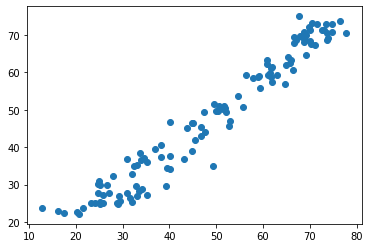

In [8]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)
print('Test accuracy:')
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_test)) )
print("R-square = %.4f" % r2_score(y_test, y_pred_test) )

plt.scatter(y_test, y_pred_test)

**(e)** Display the values of the regression coefficients (i.e., slope and intercept). Based on the absolute value of their regression coefficients, identify the top 3 predictors that best infer the future temperature. 

**Answer:**

In [9]:
print('Slope Coefficients:', regr.coef_)
print('Intercept:', regr.intercept_[0] )

Slope Coefficients: [[ 0.14474261  0.1677608   0.09225585 -0.01887733 -0.04293305 -0.02021679
  -0.13758302 -0.12411277 -0.1045951  -0.01629743  0.14405783  0.28507058]]
Intercept: 30.155855570237055


Based on the absolute value of their coefficients, the top 3 predictors are t-1 (0.28507058), t-11 (0.1677608), and t-12 (0.14474261) 

**(f)** Plot the temperature time series. Observe that the time series has a 12-month seasonal cycle.  

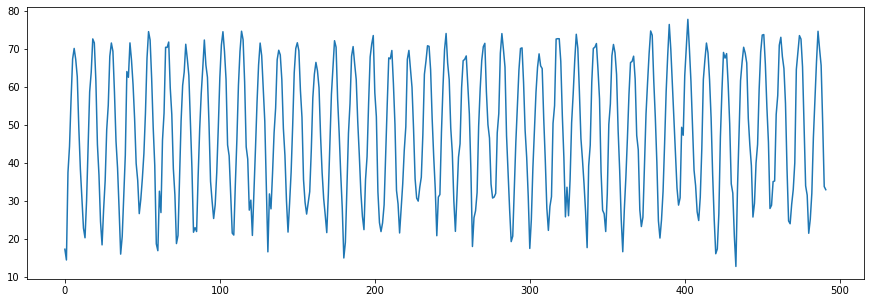

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

data["Temp"].plot(kind='line', figsize=(15,5))

**(g)** Note that the high prediction accuracy in part (d) can be attributed to the seasonal cycle of the time series. Write a function named *monthlyStandardize* that will remove the seasonal cycle by standardizing the time series with the corresponding monthly mean and monthly standard deviation values. For example, the standardized value for January 2010 is obtained by subtracting the temperature for January 2010 with the monthly mean for January (over all years) and dividing by the monthly standard deviation for January (over all years). Similarly, the standardized value for August 2015 is obtained by  subtracting the temperature for August 2015 with the monthly mean for August (over all years) and dividing by the monthly standard deviation for August (over all years). Plot the resulting standardized time series.

In [11]:
def monthlyStandardize(months, values):
    Z = values.copy()
    for month in range(1,13):
        temp = values[months==month]
        temp = (temp-temp.mean())/temp.std()
        Z[months==month] = temp
    
    return Z        

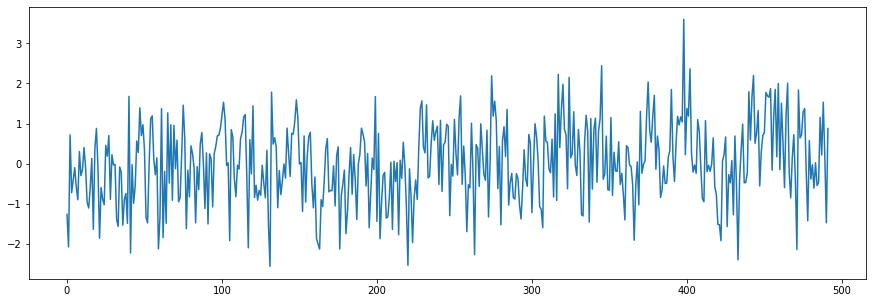

In [12]:
y = monthlyStandardize(data['Month'],data['Temp'])
y.plot(kind='line', figsize=(15,5))

**(h)** Repeat part (b) above to create the corresponding X and y dataframe objects from the standardized temperature values obtained in part (g).

In [13]:
window_size = 12

columnName = "t-" + str(window_size)
X = pd.DataFrame(y.values,columns=[columnName])

for n in range(1,window_size):
    columnName = "t-" + str(window_size-n)
    X[columnName] = y.shift(-n)

X = X[:-window_size]

X.head()

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
0,-1.265338,-2.077075,0.716492,-0.727075,-0.422052,-0.100768,-0.588353,-0.901294,0.301936,-0.299974,-0.155285,0.401257
1,-2.077075,0.716492,-0.727075,-0.422052,-0.100768,-0.588353,-0.901294,0.301936,-0.299974,-0.155285,0.401257,-0.103044
2,0.716492,-0.727075,-0.422052,-0.100768,-0.588353,-0.901294,0.301936,-0.299974,-0.155285,0.401257,-0.103044,-0.964448
3,-0.727075,-0.422052,-0.100768,-0.588353,-0.901294,0.301936,-0.299974,-0.155285,0.401257,-0.103044,-0.964448,-1.107546
4,-0.422052,-0.100768,-0.588353,-0.901294,0.301936,-0.299974,-0.155285,0.401257,-0.103044,-0.964448,-1.107546,-0.603609


In [14]:
y = y.values
y = pd.DataFrame(y[window_size:],columns=["y"])

y.head()

,y
0,-0.103044
1,-0.964448
2,-1.107546
3,-0.603609
4,0.128208


**(i)** Repeat part (c) to create the training and test sets from the dataframe object in part (h). Use the data from the first 30 years (1980 to 2009) as training set and the last 10 years (2010 to 2019) as test set.  

In [15]:
years = data['Year'].values

X_train = pd.DataFrame(X[:360])
X_test = pd.DataFrame(X[360:])
y_train = pd.DataFrame(y[:360])
y_test = pd.DataFrame(y[360:])


**(j)** Repeat part (d) by training a regression model on the training data (X_train and y_train) obtained in part (i). Apply the model to the test data and compute its root-mean-square-error and r-square values on the test data. Draw a scatter plot between the true and predicted values. Are the results better or worse than without standardization (i.e., the results from part (d))?

Test accuracy:
Root mean squared error = 1.0138
R-square = 0.0270


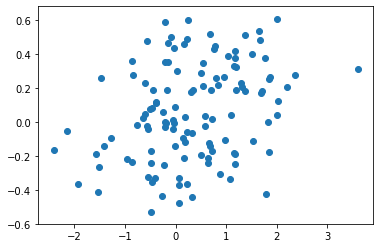

In [16]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)


print('Test accuracy:')
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_test)) )
print("R-square = %.4f" % r2_score(y_test, y_pred_test) )

plt.scatter(y_test, y_pred_test)

The results after standardization are worse because RMSE is 3.9469
and R-square is 0.9506 before standardization but RMSE is 1.0138 and R-square is 0.0270 after standardization. The R-square before standardization is CLOSER to 1 than the R-square after standardization.

**(k)** Repeat part (e) by displaying the values of the regression coefficients (i.e., slope and intercept). Based on the absolute value of their regression coefficients, identify the top 3 predictors that best infer the future temperature. 

In [17]:
print('Slope Coefficients:', regr.coef_)
print('Intercept:', regr.intercept_[0] )

Slope Coefficients: [[-0.09926041  0.04360365  0.0067474  -0.02872287  0.03799259  0.11665591
   0.03310756  0.02935252  0.0004366   0.00273582  0.11941255  0.11455179]]
Intercept: -0.06167979309599163


Based on the absolute value of their coefficients, the top 3 predictors are t-2 (0.11941255), t-7 (0.11665591) and t-1 (0.11455179)

**(l)** Next, you will combine the historical data with other climate predictors (such as El-Nino and North Atlantic Oscillation indices as well as outputs from computer-simulated climate models). Since these predictor attributes can be obtained from forecast models, you will use the value from the same month as the target attribute. For example, to predict the temperature for January 1980, you will use the 'NAO', 'Nino', and 'NCEP_Air' values for January 1980 as preditors. Make sure you apply the monthly standardization first to the temperature, NAO, Nino, and NCEP_Air attributes. Create the corresponding dataframe objects named X and y and display their first 5 rows. 

**Note:** Make sure you check carefully the values of NAO, Nino, and NCEP_Air created.

In [18]:
y = monthlyStandardize(data['Month'],data['Temp'])
nao = monthlyStandardize(data['Month'],data['NAO'])
nino = monthlyStandardize(data['Month'],data['Nino'])
ncep = monthlyStandardize(data['Month'],data['NCEP_Air'])

In [19]:
window_size = 12

columnName = "t-" + str(window_size)
X = pd.DataFrame(y.values,columns=[columnName])

for n in range(1,window_size):
    columnName = "t-" + str(window_size-n)
    X[columnName] = y.shift(-n)

X = X[:-window_size]
X['NAO'] = nao[window_size:].values
X['Nino'] = nino[window_size:].values
X['NCEP_Air'] = ncep[window_size:].values

X.head()

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,NAO,Nino,NCEP_Air
0,-1.265338,-2.077075,0.716492,-0.727075,-0.422052,-0.100768,-0.588353,-0.901294,0.301936,-0.299974,-0.155285,0.401257,-1.684700,1.141504,-0.164654
1,-2.077075,0.716492,-0.727075,-0.422052,-0.100768,-0.588353,-0.901294,0.301936,-0.299974,-0.155285,0.401257,-0.103044,-1.620431,-0.417767,-0.748996
2,0.716492,-0.727075,-0.422052,-0.100768,-0.588353,-0.901294,0.301936,-0.299974,-0.155285,0.401257,-0.103044,-0.964448,-1.801388,-0.353641,-0.264748
3,-0.727075,-0.422052,-0.100768,-0.588353,-0.901294,0.301936,-0.299974,-0.155285,0.401257,-0.103044,-0.964448,-1.107546,-1.849226,0.372944,1.029603
4,-0.422052,-0.100768,-0.588353,-0.901294,0.301936,-0.299974,-0.155285,0.401257,-0.103044,-0.964448,-1.107546,-0.603609,-1.674518,-0.123095,0.791575


In [20]:
y = y.values
y = pd.DataFrame(y[window_size:],columns=["y"])
y.head()

,y
0,-0.103044
1,-0.964448
2,-1.107546
3,-0.603609
4,0.128208


**(m)** Repeat parts (c) and (i) to create the training and test sets from the dataframe object in part (k). Use the data from the first 30 years (1980 to 2009) as training set and the last 10 years (2010 to 2019) as test set.     

In [21]:
years = data['Year'].values

X_train = pd.DataFrame(X[:360])
X_test = pd.DataFrame(X[360:])
y_train = pd.DataFrame(y[:360])
y_test = pd.DataFrame(y[360:])

**(n)**  Repeat part (d) and (j) by training a regression model on the training data (X_train and y_train) obtained in part (i). Apply the model to the test data and compute its root-mean-square-error and r-square values on the test data. Draw a scatter plot between the true and predicted values. Are the results better or worse than using historical data only (i.e., the results from part (j))? 

Test accuracy:
Root mean squared error = 0.8045
R-square = 0.3872


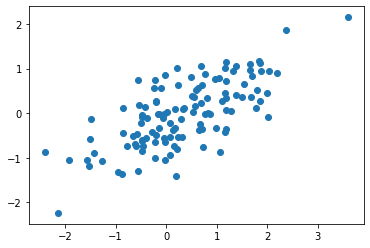

In [22]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)


print('Test accuracy:')
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_test)) )
print("R-square = %.4f" % r2_score(y_test, y_pred_test) )

plt.scatter(y_test, y_pred_test)

The results using the additional predictors are better than the results using standardization because the R-square using predictors is 0.3872 and RMSE is 0.8045 but results using standardization has a R-square of 0.0270 and RMSE is 1.0138

**(o)** Repeat parts (e) and (k) by displaying the values of the regression coefficients (i.e., slope and intercept). Based on the absolute value of their regression coefficients, identify the top 3 predictors that best infer the future temperature. 

In [23]:
print('Slope Coefficients:', regr.coef_)
print('Intercept:', regr.intercept_[0] )

Slope Coefficients: [[-0.09371772  0.04035409 -0.02311207 -0.04337565  0.02242963  0.06562289
   0.03208569 -0.01213006  0.03312602  0.00307021  0.08812635  0.08697268
   0.04771792 -0.04202164  0.65528754]]
Intercept: -0.09030804620297342


Based on the absolute value of their coefficients, the top 3 predictors are NCEP_Air (0.65528754), t-12 (0.09371772), and t-2 (0.08812635)